# Optimal Lag Selection based on MRMR and Quadratic Programming

In [1]:
# Description: 

# Aim I: MRMR criterion selection
# Aim II: Threshold (number of selected features) selection

# Author: Shilin Zhang

# Problem: Finding a robust way of choosing an optimal lag on mutiple kinds of time series regression models

# Method: Minimum Redundancy Maximum Relevance, Quadratic Programming

# Measurement: correlation coefficient, mutual information, partial correlation

# Related papers: 
# Comprehensive study of feature selection methods to solve multicollinearity problem according to evaluation criteria - Alexandr Katrutsa
# Effective Global Approaches for Mutual Information Based Feature Selection - Nguyen Xuan Vinh


In [2]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quadprog as qp

from sklearn.metrics import mutual_info_score
import pingouin as pg
from functools import reduce

from numpy.random import randint
from numpy.random import rand
np.random.seed(10)

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the data set from local file

startdate = '2012-04-01'
enddate = '2022-06-01'
datasource = 'SPY'

data = yf.download(datasource,start = startdate,end = enddate)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Raw data

data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-02,140.639999,142.210007,140.360001,141.839996,116.762001,151741100
2012-04-03,141.639999,141.880005,140.429993,141.259995,116.284538,155806700
2012-04-04,140.220001,140.339996,139.339996,139.860001,115.132072,146896000
2012-04-05,139.380005,140.199997,139.259995,139.789993,115.074448,137439400
2012-04-09,138.029999,139.839996,137.839996,138.220001,113.782036,127555900
...,...,...,...,...,...,...
2022-05-24,392.559998,395.149994,386.959991,393.890015,392.195831,91448800
2022-05-25,392.309998,399.450012,391.890015,397.369995,395.660858,91472900
2022-05-26,398.670013,407.040009,398.450012,405.309998,403.566711,82168300


In [5]:
# Parameter Setting

# maximum lag
# Setted according to econometrics textbook

max_lag = 30

target = 'Close'

In [6]:
# Function spliting train test set 

def train_test_split(data, train_test_ratio):
    
    split_point = round(data.shape[0] * train_test_ratio)
    training_data = data.iloc[0:split_point,:]
    testing_data = data.iloc[split_point: ,:]
    
    return training_data, testing_data

In [7]:
# Function generating the benchmark by shiftting one time step

def benchmark_raw_generator(data,target):
    data_shifted = data.shift()
    data_preprocessed = pd.concat([data_shifted,data[target]], axis=1)
    data_preprocessed.dropna(inplace=True)
    return data_preprocessed

In [8]:
# Shift the target to avoid the data leakage

def data_shift(train,target):
    data_shifted = train.shift()
    data_preprocessed = pd.concat([data_shifted,train[target]], axis=1)
    data_preprocessed.dropna(inplace=True)
    return data_preprocessed

### Data Preprocessing

In [9]:
# Construct the feature space

def feature_space_generator(data, max_lag):
    X = np.empty((data.shape[0],0))
    y = pd.DataFrame(data.iloc[:,-1])
    for lag in range(0,max_lag):
       X = np.concatenate((X, data.iloc[:,:-1].shift(lag)), axis = 1) 
    Xy = pd.DataFrame(np.concatenate((X, y), axis = 1)).dropna()
    X = pd.DataFrame(Xy.iloc[:,:-1])
    y = pd.DataFrame(Xy.iloc[:,-1])
    return X, y

In [10]:
# Function normalizing of sim and rel matrix

def normalization(Q):
    df = pd.DataFrame(Q)
    cols = df.columns.values.tolist()
    df_new = df.divide(df[cols].values.sum())
    return df_new

In [11]:
def definite_positive_relaxation(Q):
    lambdas = np.linalg.eig(Q)[1]
    min_lambda = np.amin(lambdas)
    if min_lambda < 0:
        Q = Q - min_lambda * np.eye(Q.shape[0])
    return np.real(Q)

In [12]:
def opt_problem_generator(X, y, sim, rel):
    if sim == 'correl':
        Q = abs(np.corrcoef(X.T))
    elif sim == 'mi':
        Q = np.zeros((X.shape[1],X.shape[1]))
        for i in range(0,X.shape[1]):
            for j in range(0,X.shape[1]):
                if(i<j):
                    Q[i,j] = mutual_info_score(X.iloc[:,i],X.iloc[:,j])
                elif(i>j):
                    Q[i,j] = Q[j,i]
    if rel == 'correl':
        b = abs(pd.DataFrame(np.concatenate((X,y),axis = 1)).corr().iloc[:-1,-1])
    elif rel == 'mi':
        b = np.zeros((X.shape[1],1))
        for i in range(0,X.shape[1]):
            b[i,0] = mutual_info_score(X.iloc[:,i],y.iloc[:,0])
    elif rel == 'pcor':
        b = abs(pd.DataFrame(np.concatenate((X,y),axis = 1)).pcorr()).iloc[:-1,-1]
    
    Q = np.array(normalization(Q))
    Q = definite_positive_relaxation(Q)
    b = np.array(normalization(b)).tolist()
    
    # Tanspose of vector b
    b = reduce(lambda x, y: x + y, b)
    b = np.array(b)
    
    return Q,b

   
$obj(x) = x.T * Q * x - b.T * x$
   

In [13]:
# Quadratic Programming solver for optimization problem

def quadprog_solver(Q,b):
    
    qp_G = 2 * Q
    qp_a = b
    
    # inequality constraint
    
    len = Q.shape[0]
    G = np.eye(len)
    h = np.zeros(len)
    qp_C = G.T
    qp_b = h
    
    return qp.solve_qp(qp_G, qp_a, qp_C, qp_b)[0]

In [14]:
sim_list = ['correl','mi']
rel_list = ['correl','mi','pcor']

# Function selecting laged features based on mutiple criterions

def multi_lag_selection(X,y,sim_list,rel_list):
    print('Scoring process start! ')
    best_list = []
    score_list = []
    for sim in sim_list:
        for rel in rel_list:
            print(sim,rel)
            Q,b =  opt_problem_generator(X, y, sim, rel)
            result = quadprog_solver(Q,b)
            best_list.append(result)
            print('Finished!')
    print(' ')
    return best_list

In [15]:
# Transfer MRMR score into feature subset according to number of features in subset

def feature_subset_generator(X,score_list,num):
    idx = list(pd.Series(score_list).sort_values(ascending = False).index)
    index_list = idx[:num+1]
    result = np.empty((X.shape[0],0))
    for i in index_list:
        result = np.concatenate((result, pd.DataFrame(X.iloc[:,i])), axis = 1) 
    return pd.DataFrame(result)

In [16]:
# Prepare the training/testing dataset
# Prepare the training/testing set according to six criterion combination

def score_2_set(X,y,score_list):
    data_list = []
    for i in score_list:
        sub_data_list = []
        for j in np.arange(0, min(100,X.shape[1])):
            subset = feature_subset_generator(X,i,j)
            Xy = pd.DataFrame(np.concatenate((subset, y), axis = 1))
            sub_data_list.append(Xy)
        data_list.append(sub_data_list)
    return data_list

## Experiment

In [17]:
# import necessary packages

import matplotlib.pyplot as plt
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

import warnings
warnings.filterwarnings("ignore")

In [18]:
def linear_regression_result(train_list,test_list):
    print('Result of Linear Regression')
    RMSE_all = []
    for i in range(0,len(train_list)):
        print('Criterion ' + str(i+1) + ': ')
        RMSE = []
        for j in range(0,len(train_list[i])):
            train = train_list[i][j]
            test = test_list[i][j]
            
            train_x = train.iloc[:,:(train.shape[1] - 1)]
            train_y = train.iloc[:,-1:]
            
            test_x = test.iloc[:,:(test.shape[1] - 1)]
            test_y = test.iloc[:,-1:]
            
            regressor = LinearRegression()
            model = TransformedTargetRegressor(regressor= regressor,
                                        transformer = MinMaxScaler()
                                        ).fit(train_x,train_y)
            y_pred = model.predict(test_x)
            
            RMSE.append(math.sqrt(mean_squared_error(y_pred, test_y)))
        print(min(RMSE))
        RMSE_all.append(RMSE)
    
    RMSE_all = pd.DataFrame(RMSE_all,index = ['cor cor','cor mi','cor pcor','mi cor','mi mi','mi pcor'],columns = np.arange(1,101)).T
    RMSE_all.plot(figsize=(20,6),
           title = 'RMSE of Linear Regression Model',
           ylabel = 'RMSE',
           xlabel = 'Number of features')
    
    print('Benchmark ' + ': ')
    train_raw_x = train.iloc[:,:(train.shape[1] - 1)]
    train_raw_y = train.iloc[:,-1:]
            
    test_raw_x = test.iloc[:,:(test.shape[1] - 1)]
    test_raw_y = test.iloc[:,-1:]
    regressor =  LinearRegression()
    model = TransformedTargetRegressor(regressor= regressor,
                                        transformer = MinMaxScaler()
                                        ).fit(train_raw_x,train_raw_y)
    y_pred = model.predict(test_raw_x)
    print(math.sqrt(mean_squared_error(y_pred, test_raw_y)))
    print(' ')
    return RMSE_all

In [19]:
def random_forest_result(train_list,test_list):
    print('Result of Random Forest')
    RMSE_all = []
    for i in range(0,len(train_list)):
        print('Criterion ' + str(i+1) + ': ')
        RMSE = []
        for j in range(0,len(train_list[i])):
            train = train_list[i][j]
            test = test_list[i][j]
            
            train_x = train.iloc[:,:(train.shape[1] - 1)]
            train_y = train.iloc[:,-1:]
            
            test_x = test.iloc[:,:(test.shape[1] - 1)]
            test_y = test.iloc[:,-1:]
            
            regressor = RandomForestRegressor()
            model = TransformedTargetRegressor(regressor= regressor,
                                        transformer = MinMaxScaler()
                                        ).fit(train_x,train_y)
            y_pred = model.predict(test_x)
            
            RMSE.append(math.sqrt(mean_squared_error(y_pred, test_y)))
        print(min(RMSE))
        RMSE_all.append(RMSE)
    RMSE_all = pd.DataFrame(RMSE_all,index = ['cor cor','cor mi','cor pcor','mi cor','mi mi','mi pcor'],columns = np.arange(1,101)).T
    
    RMSE_all.plot(figsize=(20,6),
           title = 'RMSE of Random Forest Model',
           ylabel = 'RMSE',
           xlabel = 'Number of features')
    
    print('Benchmark ' + ': ')
    train_raw_x = train.iloc[:,:(train.shape[1] - 1)]
    train_raw_y = train.iloc[:,-1:]
            
    test_raw_x = test.iloc[:,:(test.shape[1] - 1)]
    test_raw_y = test.iloc[:,-1:]
    regressor = RandomForestRegressor()
    model = TransformedTargetRegressor(regressor= regressor,
                                        transformer = MinMaxScaler()
                                        ).fit(train_raw_x,train_raw_y)
    y_pred = model.predict(test_raw_x)
    print(math.sqrt(mean_squared_error(y_pred, test_raw_y)))
    print(' ')
    return RMSE_all

In [20]:
def elastic_net_result(train_list,test_list):
    print('Result of elastic net')
    RMSE_all = []
    for i in range(0,len(train_list)):
        print('Criterion ' + str(i+1) + ': ')
        RMSE = []
        for j in range(0,len(train_list[i])):
            train = train_list[i][j]
            test = test_list[i][j]
            
            train_x = train.iloc[:,:(train.shape[1] - 1)]
            train_y = train.iloc[:,-1:]
            
            test_x = test.iloc[:,:(test.shape[1] - 1)]
            test_y = test.iloc[:,-1:]
            
            model = ElasticNet()
            # define grid
            grid = dict()
            grid['alpha'] = [0.0, 1.0, 10.0, 100.0]
            grid['l1_ratio'] = [0.1,0.5,0.7,0.9,0.95,0.99,1]
            # define search
            search = GridSearchCV(model, grid, scoring='neg_mean_squared_error')
            best = search.fit(train_x,train_y)
            best_model = ElasticNet(l1_ratio = best.best_params_.get('l1_ratio'), alpha = best.best_params_.get('alpha')).fit(train_x,train_y)
            
            y_pred = best_model.predict(test_x)
            RMSE.append(math.sqrt(mean_squared_error(y_pred, test_y)))
        print(min(RMSE))
        RMSE_all.append(RMSE)
    RMSE_all = pd.DataFrame(RMSE_all,index = ['cor cor','cor mi','cor pcor','mi cor','mi mi','mi pcor'],columns = np.arange(1,101)).T
    
    RMSE_all.plot(figsize=(20,6),
           title = 'RMSE of Elastic Net Model',
           ylabel = 'RMSE',
           xlabel = 'Number of features')
    
    print('Benchmark ' + ': ')
    train_raw_x = train.iloc[:,:(train.shape[1] - 1)]
    train_raw_y = train.iloc[:,-1:]
            
    test_raw_x = test.iloc[:,:(test.shape[1] - 1)]
    test_raw_y = test.iloc[:,-1:]
    model = ElasticNet()
    # define grid
    grid = dict()
    grid['alpha'] = [0.0, 1.0, 10.0, 100.0]
    grid['l1_ratio'] = [0.1,0.5,0.7,0.9,0.95,0.99,1]
    # define search
    search = GridSearchCV(model, grid, scoring='neg_mean_squared_error')
    best = search.fit(train_raw_x,train_raw_y)
    best_model = ElasticNet(l1_ratio = best.best_params_.get('l1_ratio'), alpha = best.best_params_.get('alpha')).fit(train_raw_x,train_raw_y)
    
    y_pred = best_model.predict(test_raw_x)
    print(math.sqrt(mean_squared_error(y_pred, test_raw_y)))
    print(' ')
    return RMSE_all

In [21]:
def svr_result(train_list,test_list):
    print('Result of SVR')
    RMSE_all = []
    for i in range(0,len(train_list)):
        print('Criterion ' + str(i+1) + ': ')
        RMSE = []
        for j in range(0,len(train_list[i])):
            train = train_list[i][j]
            test = test_list[i][j]
            
            train_x = train.iloc[:,:(train.shape[1] - 1)]
            train_y = train.iloc[:,-1:]
            
            test_x = test.iloc[:,:(test.shape[1] - 1)]
            test_y = test.iloc[:,-1:]
            
            regressor = SVR(kernel='rbf')
            model = TransformedTargetRegressor(regressor= regressor,
                                        transformer = MinMaxScaler()
                                        ).fit(train_x,train_y)
            y_pred = model.predict(test_x)
            
            RMSE.append(math.sqrt(mean_squared_error(y_pred, test_y)))
        print(min(RMSE))
        RMSE_all.append(RMSE)
    RMSE_all = pd.DataFrame(RMSE_all,index = ['cor cor','cor mi','cor pcor','mi cor','mi mi','mi pcor'],columns = np.arange(1,101)).T
    
    RMSE_all.plot(figsize=(20,6),
           title = 'RMSE of SVR Model',
           ylabel = 'RMSE',
           xlabel = 'Number of features')
    
    print('Benchmark ' + ': ')
    train_raw_x = train.iloc[:,:(train.shape[1] - 1)]
    train_raw_y = train.iloc[:,-1:]
            
    test_raw_x = test.iloc[:,:(test.shape[1] - 1)]
    test_raw_y = test.iloc[:,-1:]
    regressor = SVR(kernel='rbf')
    model = TransformedTargetRegressor(regressor= regressor,
                                        transformer = MinMaxScaler()
                                        ).fit(train_raw_x,train_raw_y)
    y_pred = model.predict(test_raw_x)
    print(math.sqrt(mean_squared_error(y_pred, test_raw_y)))
    print(' ')
    return RMSE_all

In [22]:
# Function that contains the whole process from lag training to experiment 

def QPLS(data,target):
    
    # Train/test set seperation
    training_data,testing_data = train_test_split(data, 0.7)
    
    # Generate the benchmmark dataset (raw data) for training and testing seperatly
    train_raw = benchmark_raw_generator(training_data,target)
    test_raw = benchmark_raw_generator(testing_data, target)
    
    train_preprocessed = data_shift(training_data,target)
    test_preprocessed = data_shift(testing_data,target)

    X, y = feature_space_generator(train_preprocessed, max_lag)
    test_X, test_y = feature_space_generator(test_preprocessed, max_lag)
    
    
    mrmr_score_list = multi_lag_selection(X,y,sim_list,rel_list)
    
    # Generate train and test set according to MRMR score for experiment
    train_list = score_2_set(X,y,mrmr_score_list)
    test_list = score_2_set(test_X,test_y,mrmr_score_list)
    
    # Save search space without selection as benchmark
    train_all = pd.DataFrame(np.concatenate((X, y), axis = 1))
    test_all = pd.DataFrame(np.concatenate((test_X, test_y), axis = 1))

    
    RMSE_LR = linear_regression_result(train_list,test_list)
    RMSE_RF = random_forest_result(train_list,test_list)
    RMSE_EN = elastic_net_result(train_list,test_list)
    RMSE_SVR = svr_result(train_list,test_list)
    

    return RMSE_LR, RMSE_RF,RMSE_EN,RMSE_SVR

Scoring process start! 
correl correl
Finished!
correl mi
Finished!
correl pcor
Finished!
mi correl
Finished!
mi mi
Finished!
mi pcor
Finished!
 
Result of Linear Regression
Criterion 1: 
4.8150659180080515
Criterion 2: 
4.948378511425014
Criterion 3: 
4.812410386004101
Criterion 4: 
4.8150659180080515
Criterion 5: 
4.9483785129365465
Criterion 6: 
4.812410386004101
Benchmark : 
5.029692574840149
 
Result of Random Forest
Criterion 1: 
99.10021560951779
Criterion 2: 
100.35863793250454
Criterion 3: 
99.05554905910175
Criterion 4: 
99.07355633177826
Criterion 5: 
100.46749802108818
Criterion 6: 
98.99793598432768
Benchmark : 
100.51566168387116
 
Result of elastic net
Criterion 1: 
4.806298645894679
Criterion 2: 
5.11260825473761
Criterion 3: 
4.799061277181298
Criterion 4: 
4.806736608867127
Criterion 5: 
5.178098562091134
Criterion 6: 
4.7999468465968205
Benchmark : 
4.799946846846259
 
Result of SVR
Criterion 1: 
160.4525096443513
Criterion 2: 
143.03998343967584
Criterion 3: 
157.33

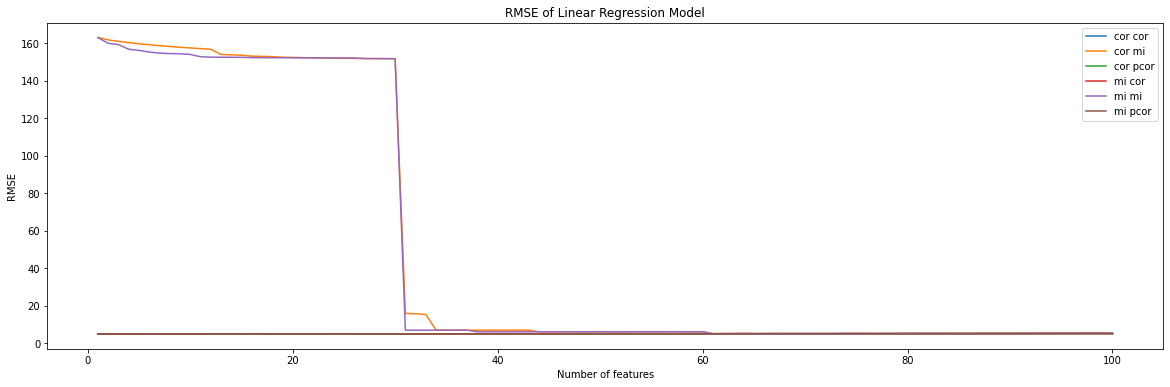

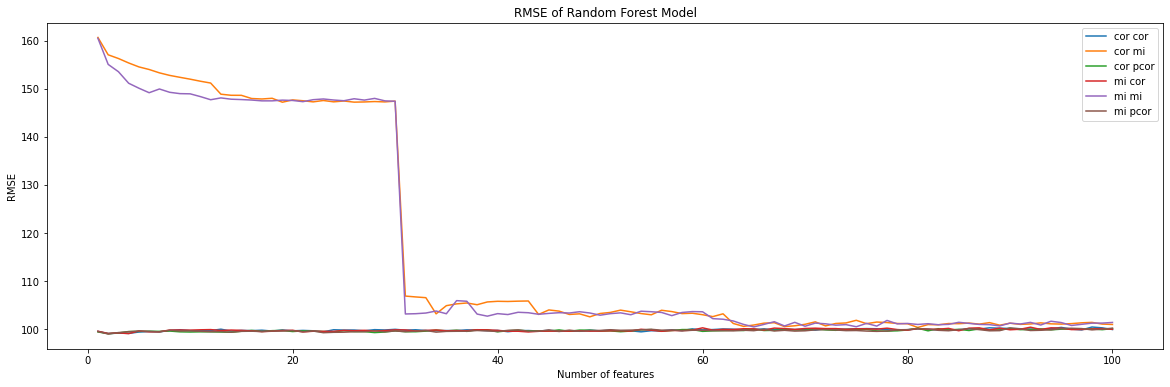

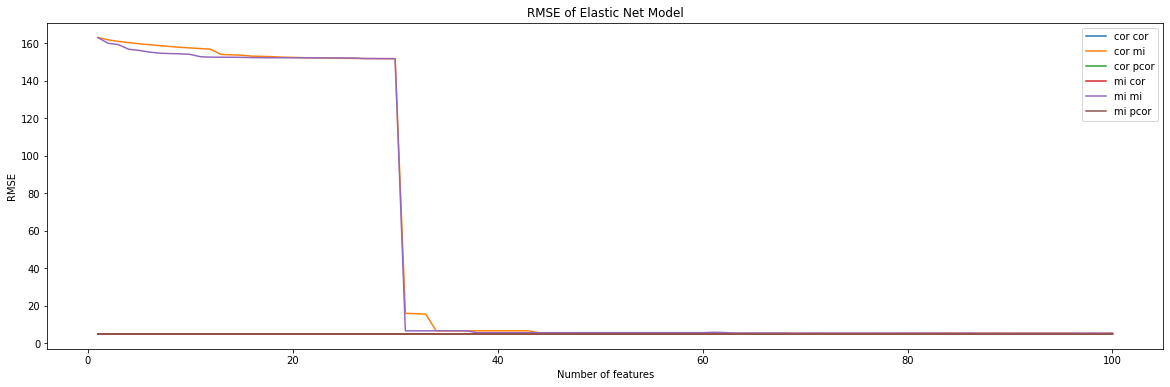

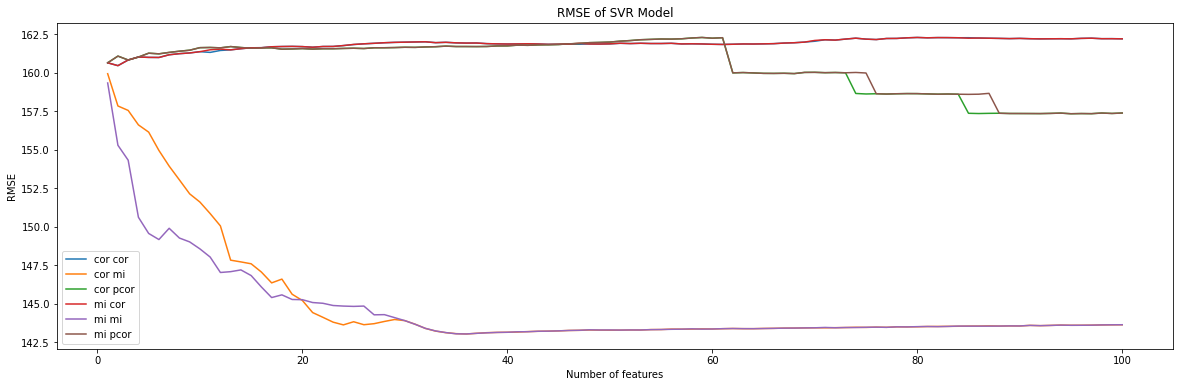

In [23]:
RMSE_LR, RMSE_RF,RMSE_EN,RMSE_SVR= QPLS(data,target)

In [24]:
RMSE_LR[RMSE_LR['cor pcor'] == min(RMSE_LR['cor pcor'])]

,cor cor,cor mi,cor pcor,mi cor,mi mi,mi pcor
8,4.879757,158.301044,4.81241,4.879757,154.513743,4.81241


In [25]:
RMSE_RF[RMSE_RF['mi pcor'] == min(RMSE_RF['mi pcor'])]

,cor cor,cor mi,cor pcor,mi cor,mi mi,mi pcor
2,99.100216,157.070425,99.055549,99.101583,155.074351,98.997936


In [26]:
RMSE_EN[RMSE_EN['mi pcor'] == min(RMSE_EN['mi pcor'])]

,cor cor,cor mi,cor pcor,mi cor,mi mi,mi pcor
93,4.823269,5.247955,4.800001,4.823269,5.189557,4.799947
94,4.823269,5.253757,4.800001,4.823269,5.190642,4.799947
95,4.823269,5.251514,4.800001,4.823269,5.197449,4.799947
96,4.823269,5.252401,4.800001,4.823269,5.197542,4.799947
97,4.823269,5.130763,4.800001,4.823269,5.205634,4.799947
98,4.823269,5.224353,4.800001,4.823269,5.205445,4.799947


In [27]:
RMSE_SVR[RMSE_SVR['cor mi'] == min(RMSE_SVR['cor mi'])]

,cor cor,cor mi,cor pcor,mi cor,mi mi,mi pcor
36,161.917525,143.039983,161.693154,161.917525,143.040059,161.693154


In [28]:
RMSE_LR.to_csv('C:/Users/82422/Desktop/Result/SP/RMSE_LR.csv')

In [29]:
RMSE_RF.to_csv('C:/Users/82422/Desktop/Result/SP/RMSE_RF.csv')

In [30]:
RMSE_EN.to_csv('C:/Users/82422/Desktop/Result/SP/RMSE_EN.csv')

In [31]:
RMSE_SVR.to_csv('C:/Users/82422/Desktop/Result/SP/RMSE_SVR.csv')